# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 4: Multiple and Polynomial Regression 

**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors:** Pavlos Protopapas and Kevin Rader<br/>
**Lab Instructor:** Rahul Dave<br/>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents

<ol start="0">
<li> Learning Goals </li>
<li> Polynomial Regression, and Revisiting the Cab Data</li>
<li> Multiple regression and exploring the Football data </li>
<li> A nice trick for forward-backwards </li>
</ol>

## Learning Goals
After this lab, you should be able to
 - Implement arbitrary multiple regression models in both SK-learn and Statsmodels
 - Interpret the coefficent estimates produced by each model, including transformed and dummy variables

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

`statsmodels` is focused on the _inference_ task: guess good values for the betas and discuss how certain you are in those answers. 

`sklearn` is focused on the _prediction_ task: given \[new\] data, guess what the response value is. As a result, statsmodels has lots of tools to discuss confidence, but isn't great at dealing with test sets. Sklearn is great at test sets and validations, but can't really discuss uncertainty in the parameters or predictions. In short:

  - sklearn is about putting a line through it and predicting new values using that line. If the line gives good predictions on the test set, who cares about anything else?
  - statsmodels assumes more about how the data were generated, and (if the assumptions are correct) can tell you about uncertainty in the results


### Some terms


- **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model, negative is worse than the trivial model
- **F-statistic**: A value testing whether we're likely to see these results (or even stronger ones) if none of the predictors actually mattered.
- **Prob (F-statistic)**: The probability that we'd see these results (or even stronger ones) if none of the predictors actually mattered. If this probability is small then either A) some combination of predictors actually matters or B) something rather unlikely has happened
- **coef**: The estimate of each beta. This has several sub-components:
  - **std err**: The amount we'd expect this value to wiggle if we re-did the data collection and re-ran our model. More data tends to make this wiggle smaller, but sometimes the collected data just isn't enough to pin down a particular value.
  - **t and P>|t|**: similar to the F-statistic, these measure the probability of seeing coefficients this big (or even bigger) if the given variable didn't actually matter. Small probability doesn't necessarily mean the value matters
  - **\[0.025 0.975\]**: Endpoints of the 95% confidence interval. This is a interval drawn in a clever way and which gives an idea of where the true beta value might plausibly live. (If you want to understand why "there's a 95% chance the true beta is in the interval" is _wrong_, start a chat with Will : )
  

## Part 1: Polynomial Regression, and Revisiting the Cab Data

In [151]:
# read in the data, break into train and test
cab_df = pd.read_csv("data/dataset_1.txt")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [7]:
cab_df.shape

(1250, 2)

In [152]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60
y_test = test_data['PickupCount'].values


def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # if needed, build the design matrix
    if poly_transformer:
        design_mat = poly_transformer.fit_transform(x_vals)
    else:
        design_mat = x_vals
    
    # make the prediction at each x value
    prediction = cur_model.predict(design_mat)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

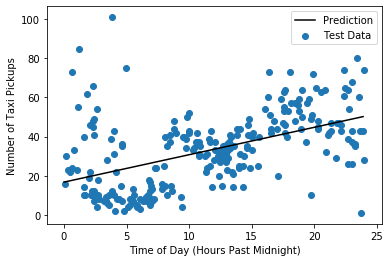

In [153]:
from sklearn.linear_model import LinearRegression
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [11]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

We can see that there's still a lot of variation in cab pickups that's not being caught by a linear fit. And the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. However, we can add columns to our design matrix for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a wigglier polynomial that will better fit the data.

We'll be using sklearn's `PolynomialFeatures` to take some of the tedium out of building the new design matrix. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$ it will directly return the new design matrix.

In [12]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
new_features = transformer_3.fit_transform(X_train)
new_features

array([[6.73333333e+00, 4.53377778e+01, 3.05274370e+02],
       [2.18333333e+00, 4.76694444e+00, 1.04078287e+01],
       [1.41666667e+00, 2.00694444e+00, 2.84317130e+00],
       ...,
       [1.96666667e+01, 3.86777778e+02, 7.60662963e+03],
       [1.17333333e+01, 1.37671111e+02, 1.61534104e+03],
       [1.42000000e+01, 2.01640000e+02, 2.86328800e+03]])

A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a 'transformer' in sklearn. We'll be using several transformers that learn a transformation on the training data and then apply that transformation on future data. On these (more typical) transformers it makes sense to have a `.fit()` and a separate `.transform()`. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above.
- You rarely want to `include_bias` (a column of all 1s), since sklearn will add it automatically and statsmodels can just `add_constant` right before you fit to the design matrix
- If you want polynomial features for a several different variables, you should call `.fit_transform()` separately on each column and append all the results to the design matrix (unless you also want interaction terms between the newly-created features). See `np.concatenate` for joining arrays.

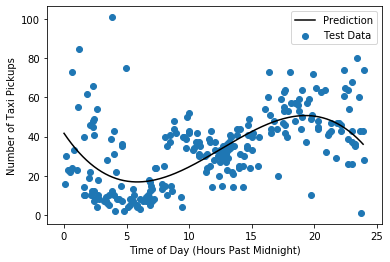

In [13]:
fitted_cab_model3 = LinearRegression().fit(new_features, y_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

*your answer here*


In [34]:
# your code here
print("R squared score of cubic model:",fitted_cab_model3.score(transformer_3.fit_transform(X_test), y_test))

R squared score of cubic model: 0.33412512570778763


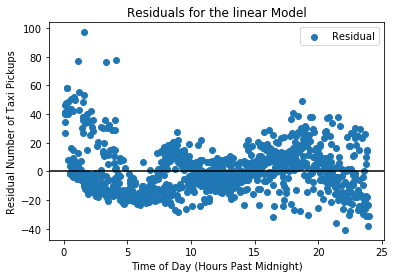

In [33]:
# your code here
prediction = fitted_cab_model0.predict(X_train)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the linear Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend()

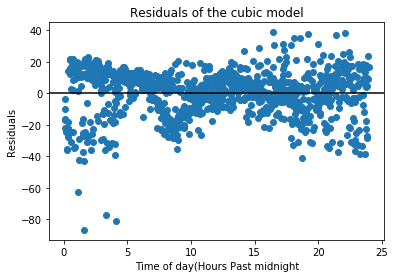

In [31]:
# your code here
y_predict = fitted_cab_model3.predict(transformer_3.fit_transform(X_train))
residual = y_predict - y_train
plt.scatter(X_train, residual)
plt.axhline(0, color='k')
plt.title('Residuals of the cubic model')
plt.xlabel('Time of day(Hours Past midnight')
plt.ylabel('Residuals')
plt.show()

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

<hr style="height:3px">
## Part 2: Multiple regression and exploring the Football data
Let's move on to a truly interesting dataset. The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by transfermrkt.com.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on transfermrkt.com on July 20th, 2017  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.

## Part 2.1: Import and verification and grouping

In [89]:
league_df = pd.read_csv("data/league_data.txt")
print(league_df.dtypes)
league_df.head()

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [180]:
league_df.shape

(460, 17)

In [54]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. Use the `train_test_split` function to and its 'stratify' argument to split the data, keeping equal representation of each region (This will not work out of the box on this data. Deal with the resulting issue).
2. Deal with the issue you encountered above.
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

*your answer here*:


In [154]:
# your code here
try:
    # Doesn't work: a value is missing
    train_data, test_data = train_test_split(league_df, test_size = 0.2, 
                                             stratify=league_df['region'])
except:
    # Count the missing lines and drop them
    missing_rows = np.isnan(league_df['region'])
    league_df = league_df.dropna(subset=['region'])
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'])

In [155]:
train_data.shape, test_data.shape

((368, 17), (92, 17))

Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [71]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

,market_value,page_views,fpl_points
position,,,
AM,28.517857,1423.5,218
CB,9.211765,341.0,178
CF,14.767857,689.5,224
CM,11.014706,456.0,149
DM,12.388889,564.0,105
GK,6.929412,436.0,149
LB,8.233333,362.5,135
LM,4.000000,325.5,99
LW,12.260345,474.0,264


In [100]:
league_df.position.unique()

array(['LW', 'AM', 'GK', 'RW', 'CB', 'RB', 'CF', 'LB', 'DM', 'RM', 'CM',
       'SS', 'LM'], dtype=object)

In [101]:
train_data.groupby(['big_club', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

market_value   page_views  fpl_points
big_club position                                       
0        AM           13.464286   554.714286   51.428571
         CB            4.461458   274.145833   41.291667
         CF            8.550000   892.400000   55.542857
         CM            6.647059   331.676471   40.500000
         DM            7.384615   331.230769   42.692308
         GK            4.659091   372.045455   54.363636
         LB            4.909091   243.409091   47.681818
         LM            4.375000   370.500000   52.833333
         LW            7.117647   459.294118   48.294118
         RB            3.579545   252.909091   44.409091
         RM            4.333333   280.333333    1.666667
         RW            7.776316   573.368421   49.894737
         SS            6.916667  1861.666667   51.500000
1        AM           39.285714  2373.000000  146.857143
         CB           18.860000   936.440000   62.240000
         CF           25.142857  2209.642857   81.285714
         CM           24.615385  1942.000000   75.076923
         DM           21.045455  1226.272727   59.818182
         GK           13.430769   813.538462   66.615385
         LB           17.000000   999.571429   78.142857
         LM            5.000000   936.000000   26.000000
         LW           26.388889  2102.333333  103.222222
         RB           20.416667   834.333333  104.333333
         RM           22.000000  1519.000000   83.000000
         RW           30.000000  1324.166667   71.000000
         SS           38.000000  2196.000000  180.000000

<hr style="height:3px">
## Part 2.2: Linear regression on the football data
This section of the lab focuses on fitting a model to the football data and interpreting the model results. The model we'll use is

$$\text{market_value} \approx \beta_0 + \beta_1\text{fpl_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4log_2\left(\text{page_views}\right) + \beta_5\text{new_signing} +\beta_6\text{big_club} + \beta_7\text{position_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. Build a design matrix function and fit this model to the training data. How good is the overall model?
2. Interpret the regression model. What is the meaning of the coefficient for:
    - age and age$^2$
    - $log_2($page_views$)$
    - big_club
2. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

In [168]:
# your code here
def design_matrix(input_df):
    input_df = input_df[['fpl_points', 'age', 'page_views', 'new_signing', 'big_club', 'position_cat']].copy()
    input_df['age_squared'] = league_df['age']**2
    input_df['log2_pageviews'] = np.log2(league_df['page_views'])
    
    # Re-indexing
    output = input_df[['fpl_points', 'age', 'age_squared', 'log2_pageviews', 'new_signing', 'big_club', 'position_cat']]
    
    # Add a column of constants
    output = sm.add_constant(output)
    return output

# X_train and Y_train
X_train_arranged = design_matrix(train_data)
Y_train = train_data['market_value']

# Fit Linear Reg. model
fitted_league_model = LinearRegression().fit(X_train_arranged, Y_train)

X_test_arranged = design_matrix(test_data)
Y_test = test_data['market_value']

r2_score(Y_test, fitted_league_model.predict(X_test_arranged))

D:\Anaconda\envs\test\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
D:\Anaconda\envs\test\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


0.701662095686778

In [169]:
# Ordinary Least Squares Inference (from statsmodels library)
fitted_league_model = OLS(endog= Y_train, exog= X_train_arranged, hasconst=True).fit()
fitted_league_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market_value   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     105.9
Date:                Tue, 28 Jan 2020   Prob (F-statistic):           2.00e-83
Time:                        18:24:47   Log-Likelihood:                -1242.6
No. Observations:                 368   AIC:                             2501.
Df Residuals:                     360   BIC:                             2532.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -96.7623     14.496     -6.675      0.000    -125.269     -68.256
fpl_points         0.0828      0.009      9.120      0.000       0.065       0.101
age                6.9370      1.033      6.712      0.000       4.905       8.969
age_squared       -0.1363      0.019     -7.170      0.000      -0.174      -0.099
log2_pageviews     1.8193      0.375      4.854      0.000       1.082       2.556
new_signing        1.0615      1.056      1.005      0.315      -1.015       3.138
big_club           9.8271      1.052      9.345      0.000       7.759      11.895
position_cat      -0.9344      0.432     -2.161      0.031      -1.785      -0.084
==============================================================================
Omnibus:                      128.796   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              606.154
Skew:                           1.429   Prob(JB):                    2.37e-132
Kurtosis:                       8.601   Cond. No.                     2.98e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 1. How good is the overall model? The model is good with an adjusted R squared value of 0.67.
# 2. Interpret the regression model. 
# What is the meaning of the coefficient for: - age and age 2  : Market value increases with age (1 year increase => 6.8 increase in market value) till a certain age after which market value drops with age.
# 𝑙𝑜𝑔2(page_views) : Multiplying page views by 2 increases market value by 1.8 units  
# big_club : The market value of players in big clubs is 9.8271 higher than that of players in non-big clubs.
# 2. What should a player do in order to improve their market value? : A player should increase his page views and move to a big club
# How many page views should a player go get to increase their market value by 10? : A player should multiply his page views by 47 to increase his market value by 10

# However the above mathematical deductions from the model may not be valid due to some correlations between the explanatory variables.
# For instance, being in a big club could attract more page views

*your answer here*


In [184]:
agecoef = fitted_league_model.params.age
age2coef = fitted_league_model.params.age_squared

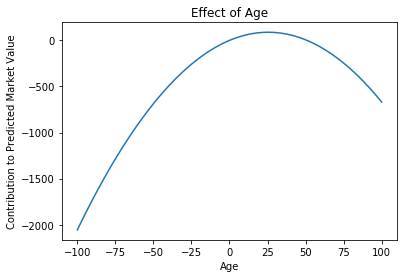

In [185]:
x_vals = np.linspace(-100,100,1000)
y_vals = agecoef*x_vals +age2coef*x_vals**2
plt.plot(x_vals, y_vals)
plt.title("Effect of Age")
plt.xlabel("Age")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

<hr style='height:3px'>
### Part 2.3: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is about -.61.

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [190]:
X_train_recoded = pd.get_dummies(X_train_arranged, columns=['position_cat'], drop_first=True)
X_test_recoded = pd.get_dummies(X_test_arranged, columns=['position_cat'], drop_first=True)

X_train_recoded.head()

,const,fpl_points,age,age_squared,log2_pageviews,new_signing,big_club,position_cat_2,position_cat_3,position_cat_4
241,1.0,175,29,841,11.982281,0,1,0,0,0
171,1.0,0,26,676,6.339850,0,0,0,1,0
404,1.0,55,27,729,9.457381,0,0,1,0,0
256,1.0,18,32,1024,8.400879,0,1,1,0,0
399,1.0,87,33,1089,8.430453,0,0,0,1,0
175,1.0,0,21,441,7.294621,0,0,1,0,0
250,1.0,73,34,1156,8.768184,1,1,0,0,1
440,1.0,133,24,576,8.945444,0,0,0,0,0
143,1.0,76,31,961,12.903882,0,0,0,0,0
85,1.0,50,28,784,7.672425,0,0,1,0,0


We've removed the original `position_cat` column and created three new ones.

#### Why only three new columns?
Why does pandas give us the option to drop the first category? 
Answer : We drop the first category because there is an intercept in the model and the dropped column is linearly dependent on the three remaining columns and intercept column. Thus it conveys no additional information. The dropped column will serve as baseline for comparing the effect of the player categories on market value.

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
Answer : We should have four dummy columns if there is no constant.

2. Fit a model and interpret the coefficient of `position_cat_2`.


In [225]:
resu = OLS(Y_train, X_train_recoded).fit()
resu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market_value   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     82.03
Date:                Tue, 28 Jan 2020   Prob (F-statistic):           1.73e-81
Time:                        20:56:01   Log-Likelihood:                -1242.4
No. Observations:                 368   AIC:                             2505.
Df Residuals:                     358   BIC:                             2544.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -97.1891     14.480     -6.712      0.000    -125.666     -68.712
fpl_points         0.0834      0.009      9.064      0.000       0.065       0.101
age                6.8792      1.044      6.591      0.000       4.827       8.932
age_squared       -0.1352      0.019     -7.035      0.000      -0.173      -0.097
log2_pageviews     1.8249      0.381      4.783      0.000       1.075       2.575
new_signing        1.0504      1.058      0.992      0.322      -1.031       3.132
big_club           9.8085      1.056      9.291      0.000       7.732      11.885
position_cat_2    -0.3487      1.018     -0.343      0.732      -2.350       1.653
position_cat_3    -1.7297      1.025     -1.688      0.092      -3.745       0.285
position_cat_4    -2.8974      1.605     -1.806      0.072      -6.053       0.258
==============================================================================
Omnibus:                      128.169   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              595.047
Skew:                           1.426   Prob(JB):                    6.13e-130
Kurtosis:                       8.538   Cond. No.                     2.98e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2.302585092994046

In [193]:
r2_score(Y_test, resu.predict(X_test_recoded))

0.698939983035672

In [197]:
X_train_recoded.shape, Y_train.shape

((368, 10), (368,))

**Answers**:
1. If our model does not have a constant, we must include all four dummy variable columns. If we drop one, we're not modeling any effect of being in that category, and effectively assuming the dropped category's effect is 0.
2. Being in position 2 (instead of position 1) has an impact between -1.54 and +2.38 on a player's market value. Since we're using an intercept, the dropped category becomes the baseline and the effect of any dummy variable is the effect of being in that category instead of the baseline category.

## Part 3: A nice trick for forward-backwards

XOR (operator ^) is a logical operation that only returns true when input differ. We can use it to implement forward-or-backwards selection when we want to keep track of whet predictors are "left" from a given list of predictors.

The set analog is "symmetric difference". From the python docs:

`s.symmetric_difference(t)	s ^ t	new set with elements in either s or t but not both`


In [201]:
set() ^ set([1,2,3])

{1, 2, 3}

In [200]:
set([1]) ^ set([1,2,3])

{2, 3}

In [199]:
set([1, 2]) ^ set([1,2,3])

{3}

<div class="exercise"><b>Exercise</b></div>

Outline a step-forwards algorithm which uses this idea

*your answer here*

In [301]:
selected_predictors = set()
all_predictors = set(['const', 'fpl_points', 'age', 'age_squared', 'log2_pageviews', 'new_signing', 'big_club', 'position_cat_2', 'position_cat_3', 'position_cat_4'])

def pick_best_predictor(selected_predictors, all_predictors):
    best_bic = float('inf')
    best_predictor = ""
    for key, val in enumerate(selected_predictors^all_predictors):
        # Get data column
        X_train_1 = X_train_recoded[[val]]
        #Fit model
        result = OLS(Y_train, X_train_1).fit()
        #Compare BIC value with the best - The best Bayesian Information Criterion value is the least
        if result.bic < best_bic:
            best_bic = result.bic
            best_predictor = val
    
    return best_predictor

# Best 1-predictor
selected_predictors.add(pick_best_predictor(selected_predictors, all_predictors))

# Best 2-predictors
selected_predictors.add(pick_best_predictor(selected_predictors, all_predictors))

# Best 3-predictors
selected_predictors.add(pick_best_predictor(selected_predictors, all_predictors))

# Best 4-predictors
selected_predictors.add(pick_best_predictor(selected_predictors, all_predictors))

# Best 5-predictors
selected_predictors.add(pick_best_predictor(selected_predictors, all_predictors))

# Best 6-predictors
selected_predictors.add(pick_best_predictor(selected_predictors, all_predictors))

selected_predictors


{'age', 'age_squared', 'big_club', 'const', 'fpl_points', 'log2_pageviews'}